In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from causalimpact import CausalImpact

In [75]:
from sklearn.linear_model import LinearRegression # to build a LR model for comparison
import matplotlib
import statsmodels as sm # to build a LOWESS model
from scipy.interpolate import interp1d # for interpolation of new data points
import plotly.graph_objects as go
import plotly.express as px 
from rdd import rdd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [76]:
import datetime

In [77]:
data = pd.read_csv('/Users/danieltom/Desktop/data/archive.csv', parse_dates= {"date" : ["Year","Month"]})

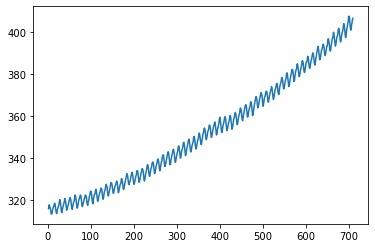

In [78]:
data = data.dropna(how='any', subset=['Carbon Dioxide (ppm)'])
data.head()
plt.plot(data['Carbon Dioxide (ppm)'])

In [79]:
data.head()
data = data.dropna(how='any', subset=['Carbon Dioxide (ppm)'])
data = data[data['date'].between('1970-01-01', '2016-12-01')]
data["raw data"]   = data["Carbon Dioxide (ppm)"]
data.loc[data.date > '2004-12-01', "Carbon Dioxide (ppm)"] = data["Carbon Dioxide (ppm)"] - 15
data['CO2_detrended'] = data['raw data'] - data['raw data'].shift(1)
data.loc[data.date > '2004-12-01', "CO2_detrended"] = data["CO2_detrended"] - 15
data = data.set_index('date')

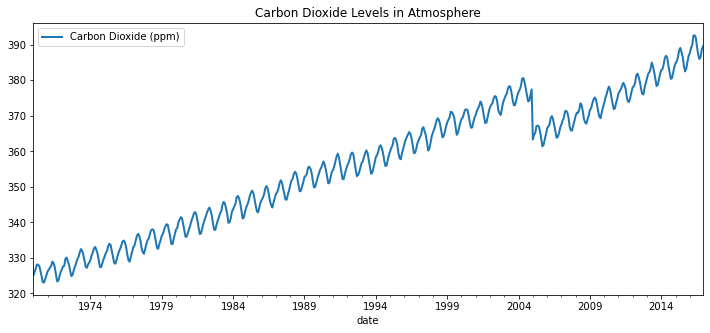

In [80]:
data.plot(y='Carbon Dioxide (ppm)', kind='line',figsize=(12,5), lw=2, title="Carbon Dioxide Levels in Atmosphere");

In [81]:
data = data.reset_index()
data

,date,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm),raw data,CO2_detrended
0,1970-01-01,1970.0411,325.06,325.04,325.27,325.24,325.06,NaN
1,1970-02-01,1970.1260,325.98,325.35,325.96,325.32,325.98,0.92
2,1970-03-01,1970.2027,326.93,325.59,326.74,325.39,326.93,0.95
3,1970-04-01,1970.2877,328.14,325.73,327.90,325.47,328.14,1.21
4,1970-05-01,1970.3699,328.08,325.18,328.45,325.55,328.08,-0.06
...,...,...,...,...,...,...,...,...
559,2016-08-01,2016.6230,387.24,403.78,403.02,404.60,402.24,-17.26
560,2016-09-01,2016.7077,386.01,404.52,401.33,404.85,401.01,-16.23
561,2016-10-01,2016.7896,386.50,405.12,401.48,405.09,401.50,-14.51
562,2016-11-01,2016.8743,388.64,405.92,403.08,405.34,403.64,-12.86


In [82]:
def valid_cutPoint(data, outcome_variable, threshold): 
    data[data[outcome_variable] > threshold]

In [83]:
def RDD(data, running_variable, outcome_variable, threshold):
    
    assert type(running_variable) is str
    assert type(outcome_variable) is str
    
    
    
    #produces the RDD plot
    a = data[data[outcome_variable] > threshold]
    aa = np.mean(a[running_variable])
    b = data[data[outcome_variable] < threshold]
    bb = np.mean(b[running_variable])
    x1 = a[outcome_variable]
    x2 = b[outcome_variable]
    x1 = x1.to_numpy()
    x2 = x2.to_numpy()
    y1 = a[running_variable]
    y2 = b[running_variable]
    y1 = y1.to_numpy()
    y2 = y2.to_numpy()
    m1, b1 = np.polyfit(x1, y1, 1)
    m2, b2 = np.polyfit(x2, y2, 1)
    x=data[outcome_variable].values 
    y=data[running_variable].values
    y_hat1 = sm.nonparametric.smoothers_lowess.lowess(y, x)
    y_hat2 = sm.nonparametric.smoothers_lowess.lowess(y, x, frac=1/20)
    fig = px.scatter(data, x=data[outcome_variable], y=data[running_variable], 
                 opacity=0.8, color_discrete_sequence=['black'])
    fig.add_traces(go.Scatter(x=y_hat2[:,0], y=y_hat2[:,1], name='LOWESS, frac=1/20', line=dict(color='orange')))
    fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="red")
    
    
    #prints the difference just before and just after the threshold -- I'M NOT SURE IF I NEED THIS, SHOULD I PUT THIS IN A DIFF FUNCTION??
    df = data[data[outcome_variable] == threshold].reset_index()
    split_val = df._get_value(0, running_variable)
    
    low = data[(data[running_variable] <= split_val) & (data[running_variable] >= split_val * .998)]
    low_mean = np.mean(low[running_variable])
    high = data[(data[running_variable] >= split_val) & (data[running_variable] <= split_val * 1.002)]
    high_mean = np.mean(high[running_variable])
    diff = str(high_mean - low_mean)
    print("The diff is " + diff)
    
    return fig

In [84]:
#function that calculates the difference just before and just after the threshold

def dif(data, running_variable, threshold): 
    low = data[(data[running_variable] <= threshold) & (data[running_variable] >= threshold * .998)]
    l = np.mean(low[running_variable])
    high = data[(data[running_variable] >= threshold) & (data[running_variable] <= threshold * 1.002)]
    h = np.mean(high[running_variable])
    diff = str(h - l)
    print("The diff is " + diff)
    

In [85]:
#function that returns the variables present in the particular dataframe -- in a list

def variables(data):
    x = list(data.columns.values)
    return x

In [86]:
def variables_minus_outcome(data,outcome_var):
    new_data = data.drop(outcome_var, axis=1)
    return variables(new_data)
    

In [87]:
def possibleCutPoints(data, running_variable):
    if type(data[running_variable][0]) is bool:  
        return "There cannot be a cut point where the values are booleans"
    if type(data[running_variable][0]) is list: 
        return "There cannot be a cut point where the values is a list"
    if type(data[running_variable][0]) is tuple: 
        return "There cannot be a cut point where the values is a tuple"
    if type(data[running_variable][0]) is range: 
        return "There cannot be a cut point where the values is a range"
    if type(data[running_variable][0]) is dict: 
        return "There cannot be a cut point where the values is a dictionary"
    return list(data[running_variable])

In [88]:
def data_type_running_var(data,running_variable): 
    return type(data[running_variable][0])

In [89]:
def same_data_type_filter(data, outcome_variable): 
    filtered_data = data
    for column in variables(data): 
        if type(column[0]) != type(data[outcome_variable][0]):
            filtered_data = filtered_data.drop(column, axis=1)
    return variables(filtered_data)

In [90]:
def correct_input_check_integer(data, entered_value, outcome_variable): 
    result = data[outcome_variable].isin(entered_value)
    if result: 
        return entered_value
    else: 
        return "This value is not in the selected column" 

In [91]:
##not sure if this is right

def datetime_check(data):
    returned = data
    for column in variables(data): 
        if type(column[0]) is not datetime: 
            returned.drop(column, axis=1)
    return variables(returned) 

In [92]:
def possible_datetime_values(data, selected_column):  
    return data[selected_column]

In [93]:
def possible_float_values(data, selected_column):  
    return data[selected_column]

In [94]:
def float_check(data):
    returned = data
    for column in variables(data): 
        if type(column[0]) is not float: 
            returned.drop(column, axis=1)
    return variables(returned) 

In [95]:
def string_check(data):
    returned = data
    for column in variables(data): 
        if type(column[0]) is not str: 
            returned.drop(column, axis=1)
    return variables(returned) 

In [96]:
def possible_string_values(data, selected_column):  
    return data[selected_column]

In [97]:
RDD(data, 'Carbon Dioxide (ppm)', 'Decimal Date', 2004.9563)

The diff is 0.5993650793650431
